## Predicting home sales prices

Description - with 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home using the supplied training and testing data.

In [1]:
# load libraries and data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import linear_model
from xgboost import XGBRegressor
sns.set()
plt.style.use("bmh")

path = 'C:/Documents/'
df_train = pd.read_csv(path+'train.csv')
df_test = pd.read_csv(path+'test.csv')

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Data shape
print(f'Shape of train set: {df_train.shape}')
print(f'Shape of test set: {df_test.shape}')
print('Columns in train and not in test:', [i for i in df_train.columns if i not in df_test.columns])

Shape of train set: (1460, 81)
Shape of test set: (1459, 80)
Columns in train and not in test: ['SalePrice']


In [3]:
# Quick look
df_train

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
...          ...       ...  ...      ...    ...    ...         ...     ...   
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
0         2   2008        WD         Normal     208500  
1         5   2007        WD         Normal     181500  
2         9   2008        WD         Normal     223500  
3         2   2006        WD        Abnorml     140000  
4        12   2008        WD         Normal     250000  
...     ...    ...       ...            ...        ...  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[1460 rows x 81 columns]

## Data cleaning and pre-processing

### Dependent Variable (label)

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<AxesSubplot: xlabel='SalePrice', ylabel='Count'>

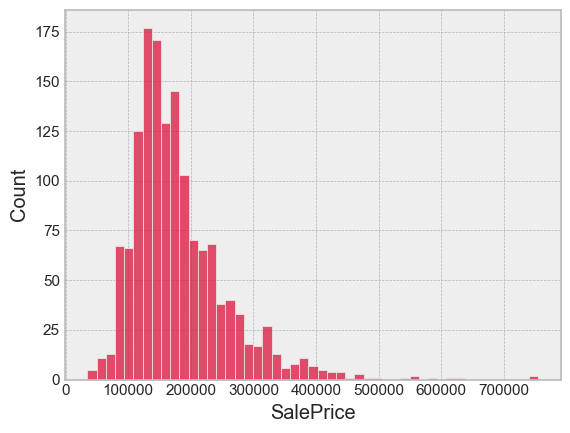

In [4]:
# Explore distribution and outliers
print(df_train['SalePrice'].describe())
sns.histplot(df_train['SalePrice'], color='crimson') # distribution (hist) plot

We can see that there are no missing values, the min is above zero, and there are no extreme outliers at the right tail of the distribution.

However, the distribution is positively skewed (log-normal).

count    1460.000000
mean       12.024057
std         0.399449
min        10.460271
25%        11.775105
50%        12.001512
75%        12.273736
max        13.534474
Name: log_price, dtype: float64


<AxesSubplot: xlabel='log_price', ylabel='Count'>

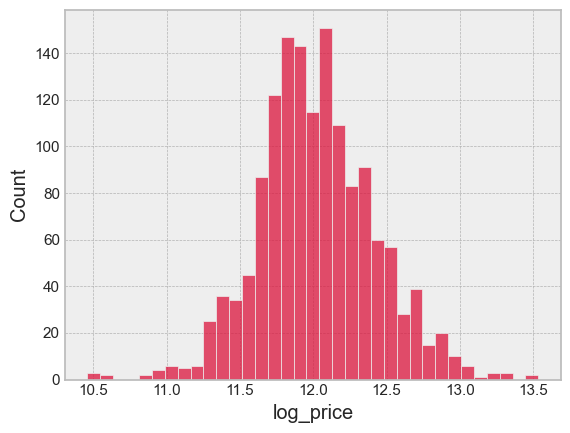

In [5]:
# approximate normal distribution -- log transformation
df_train['log_price'] = np.log1p(df_train['SalePrice']) # log(1+x)
print(df_train['log_price'].describe())
sns.histplot(df_train['log_price'], color='crimson') # distribution (hist) plot

### Features

In [6]:
df_train['train'], df_test['train'] = 1,0
df = pd.concat([df_train,df_test]).copy() # Examine both dataframes
df.drop(columns=['Id','SalePrice','log_price'], inplace=True) # not features
df['MSSubClass'] = df['MSSubClass'].astype('object') # data_description.txt shows its numbers are categories
df['MoSold'] = df['MoSold'].astype('object') # indicator for each month
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   object 
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [7]:
# Number of missing values per rows
null_rows = df.isnull().sum(axis=1)
null_rows.sort_values(ascending=False)

387     16
1011    15
533     15
660     15
1431    15
        ..
1387     2
810      2
991      2
1328     1
1386     1
Length: 2919, dtype: int64

In [8]:
# Missing values
pct_missing = {}
for col in df.columns:
    pct_missing[col] = (df[col].isnull().sum()/df[col].isnull().count())

pct_missing = dict(sorted(pct_missing.items(), key=lambda item: item[1],reverse=True)) # sort by values
{k:v for k,v in pct_missing.items() if v != 0} # show only vars with missing data

{'PoolQC': 0.9965741692360397,
 'MiscFeature': 0.9640287769784173,
 'Alley': 0.9321685508735869,
 'Fence': 0.8043850633778691,
 'FireplaceQu': 0.48646796848235696,
 'LotFrontage': 0.16649537512846865,
 'GarageYrBlt': 0.05447070914696814,
 'GarageFinish': 0.05447070914696814,
 'GarageQual': 0.05447070914696814,
 'GarageCond': 0.05447070914696814,
 'GarageType': 0.05378554299417609,
 'BsmtCond': 0.028091812264474134,
 'BsmtExposure': 0.028091812264474134,
 'BsmtQual': 0.02774922918807811,
 'BsmtFinType2': 0.027406646111682084,
 'BsmtFinType1': 0.027064063035286058,
 'MasVnrType': 0.008221993833504625,
 'MasVnrArea': 0.0078794107571086,
 'MSZoning': 0.0013703323055841042,
 'Utilities': 0.0006851661527920521,
 'BsmtFullBath': 0.0006851661527920521,
 'BsmtHalfBath': 0.0006851661527920521,
 'Functional': 0.0006851661527920521,
 'Exterior1st': 0.00034258307639602604,
 'Exterior2nd': 0.00034258307639602604,
 'BsmtFinSF1': 0.00034258307639602604,
 'BsmtFinSF2': 0.00034258307639602604,
 'BsmtUnf

In [9]:
# Dropping variables with many missing observations
for data in [df,df_train,df_test]:
    data.drop(columns=[k for k,v in pct_missing.items() if v>0.2], inplace=True)

print('Dropped columns:', [k for k,v in pct_missing.items() if v>0.2]) # drop variables with more than 20% missing values

Dropped columns: ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']


In [10]:
# Columns for imputation
missing_vars = [k for k,v in pct_missing.items() if ((v<0.2) & (v!=0))]
len(missing_vars)
df[missing_vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   2433 non-null   float64
 1   GarageYrBlt   2760 non-null   float64
 2   GarageFinish  2760 non-null   object 
 3   GarageQual    2760 non-null   object 
 4   GarageCond    2760 non-null   object 
 5   GarageType    2762 non-null   object 
 6   BsmtCond      2837 non-null   object 
 7   BsmtExposure  2837 non-null   object 
 8   BsmtQual      2838 non-null   object 
 9   BsmtFinType2  2839 non-null   object 
 10  BsmtFinType1  2840 non-null   object 
 11  MasVnrType    2895 non-null   object 
 12  MasVnrArea    2896 non-null   float64
 13  MSZoning      2915 non-null   object 
 14  Utilities     2917 non-null   object 
 15  BsmtFullBath  2917 non-null   float64
 16  BsmtHalfBath  2917 non-null   float64
 17  Functional    2917 non-null   object 
 18  Exterior1st   2918 non-null 

#### Numeric features

In [11]:
numeric_features = df.dtypes[df.dtypes != "object"].index # a list of numeric features names
print('Number of numeric features:', len(numeric_features))

Number of numeric features: 35


<timed exec>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


Wall time: 10.2 s


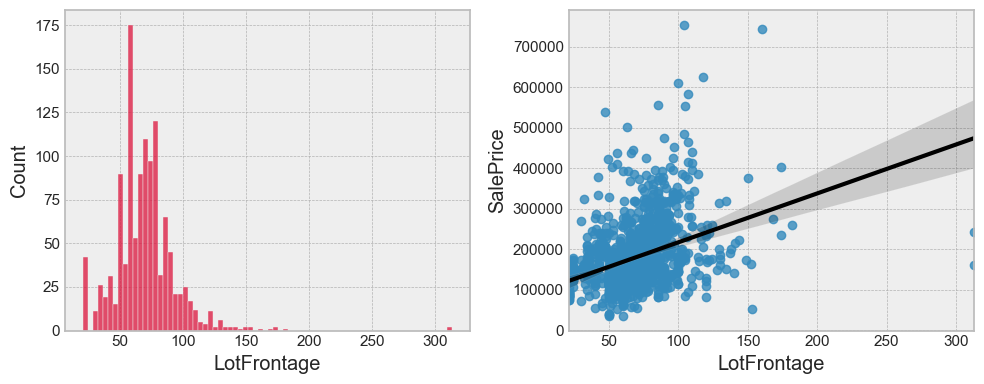

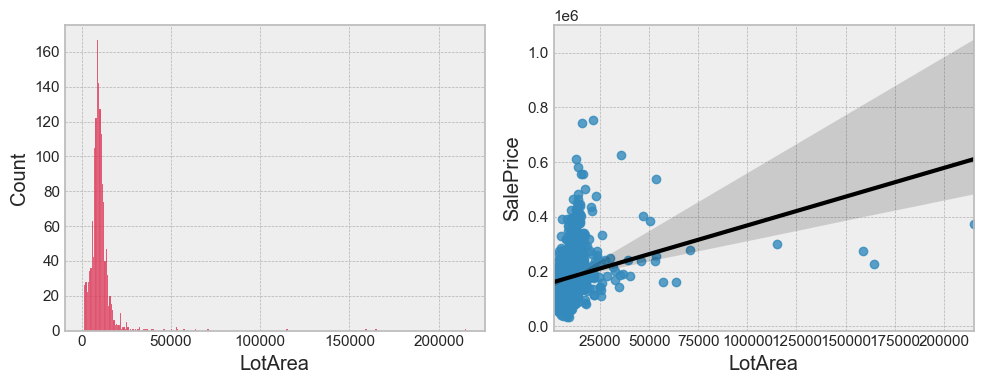

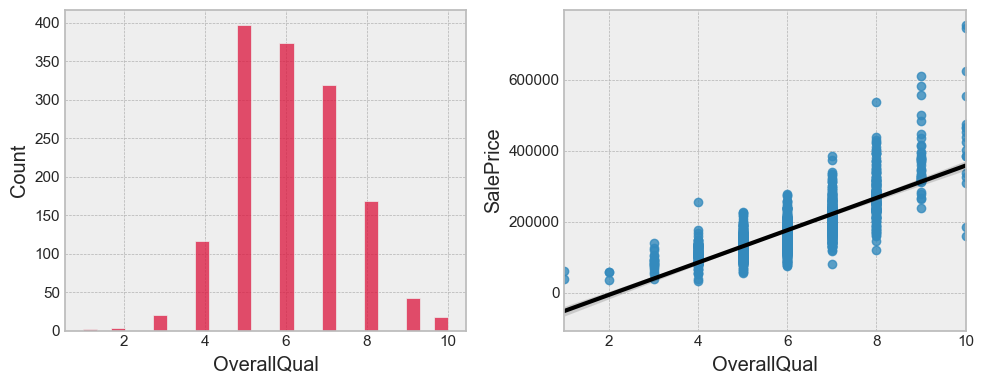

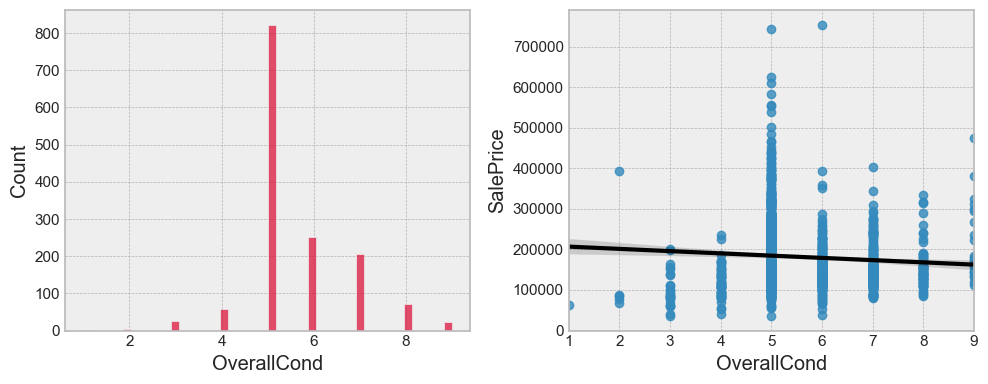

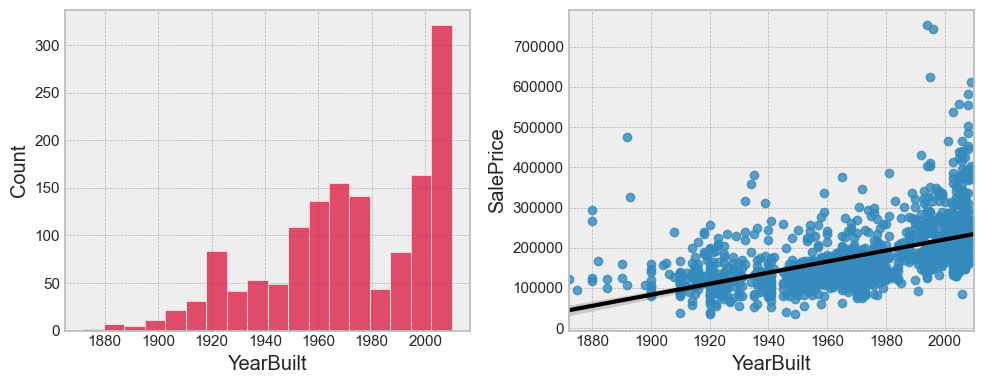

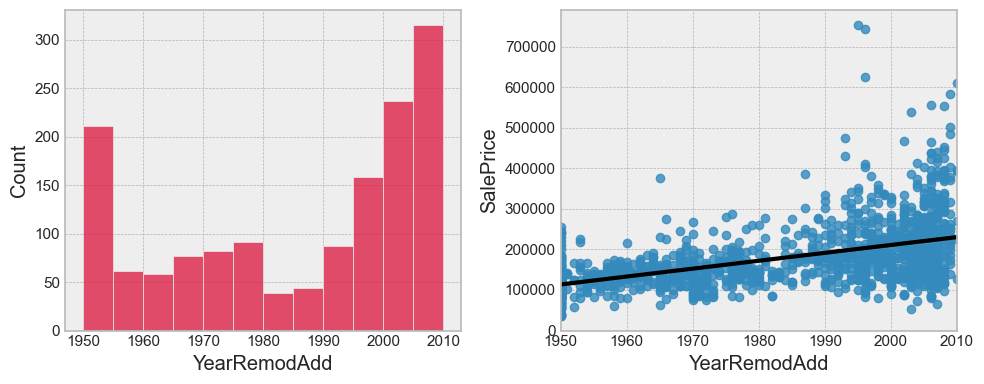

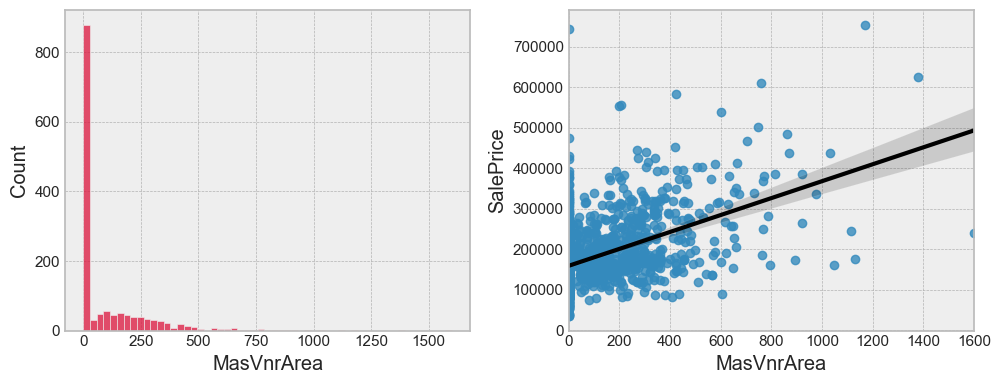

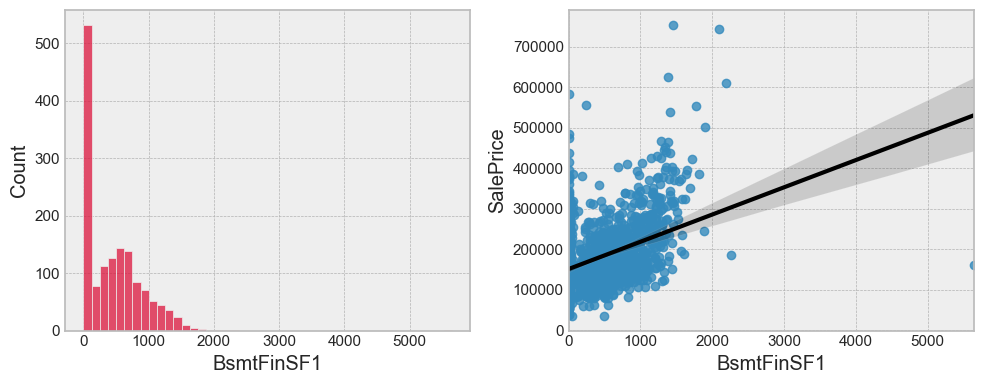

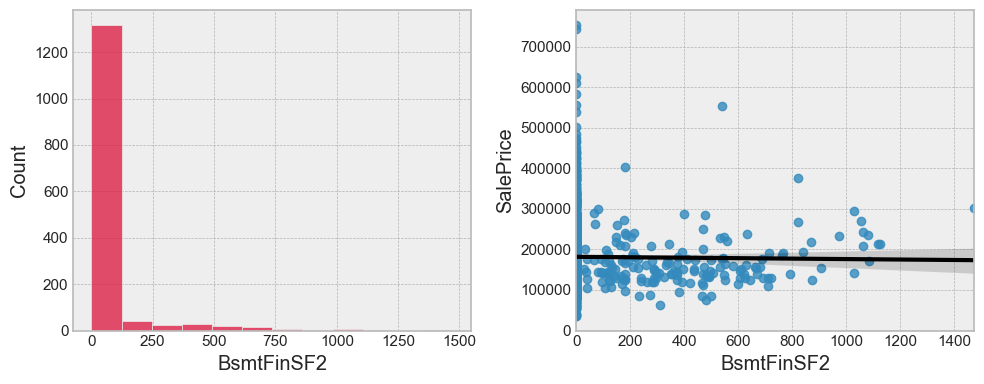

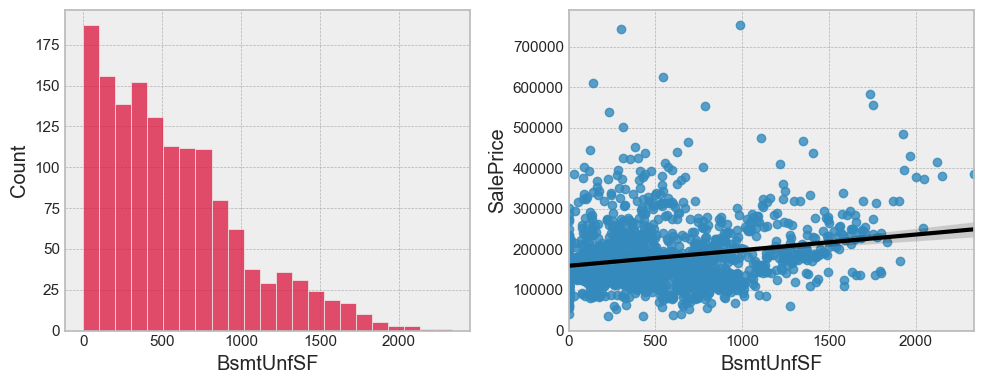

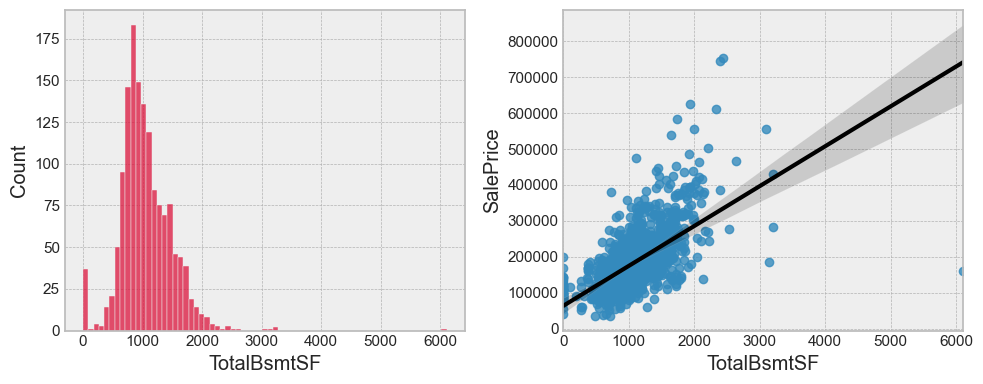

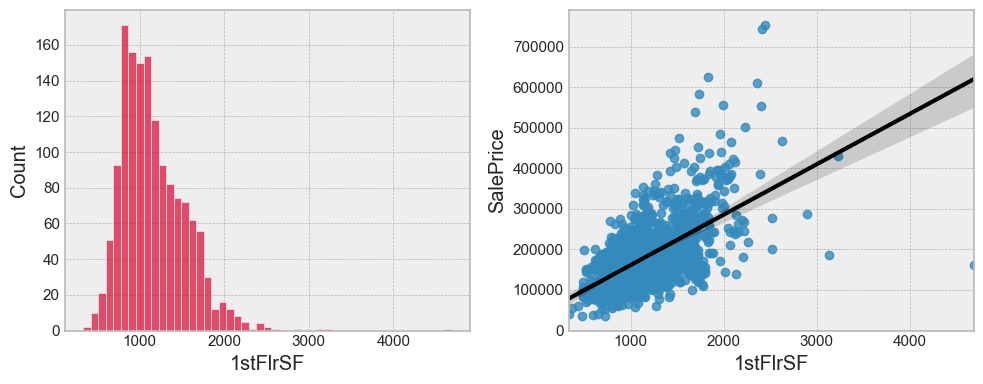

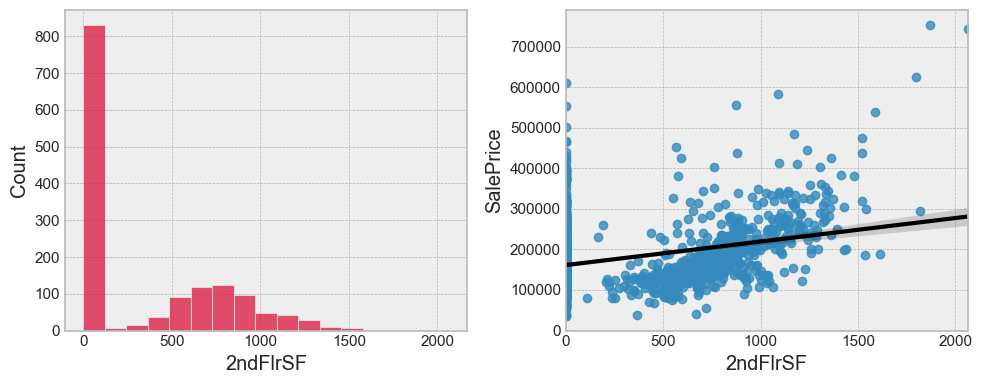

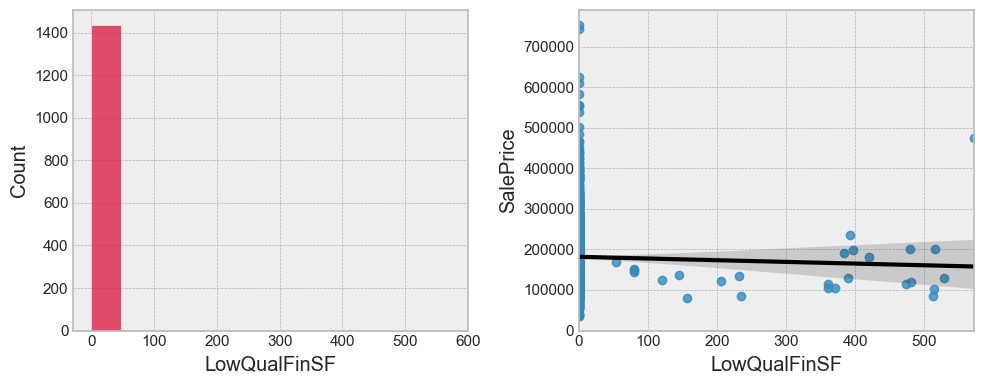

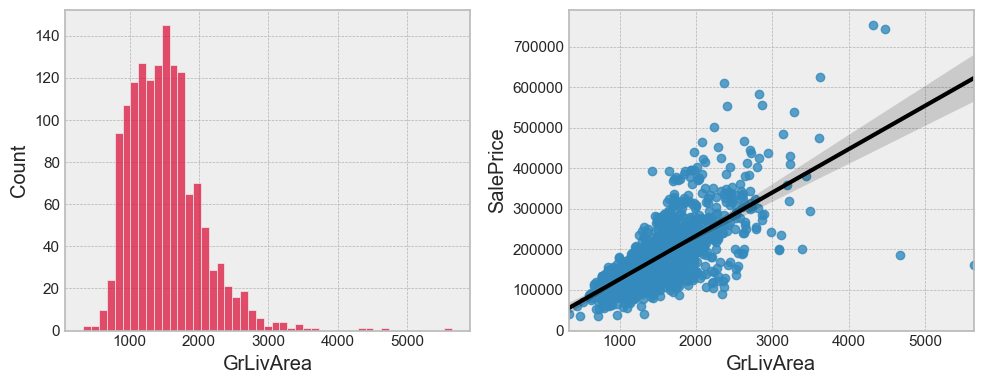

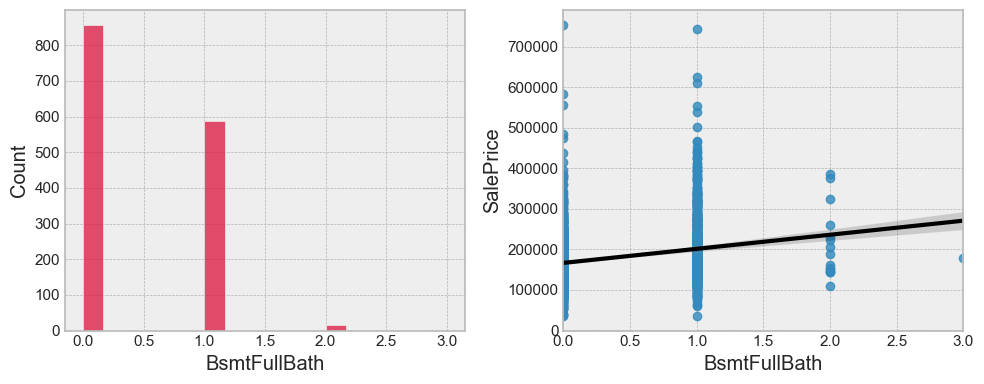

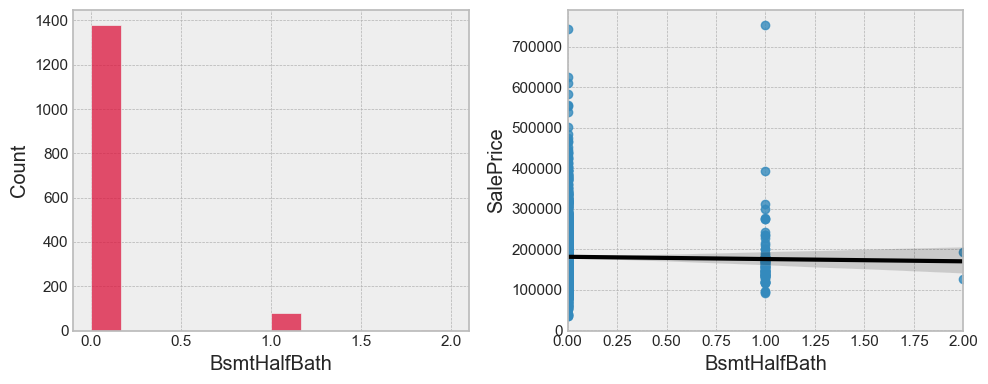

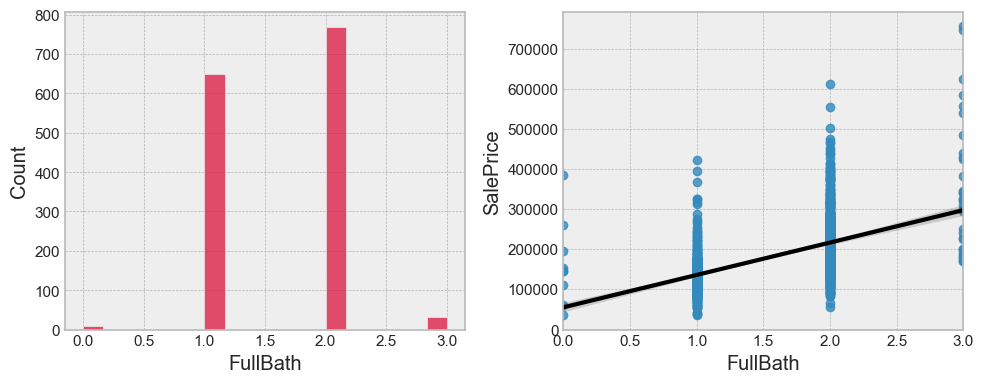

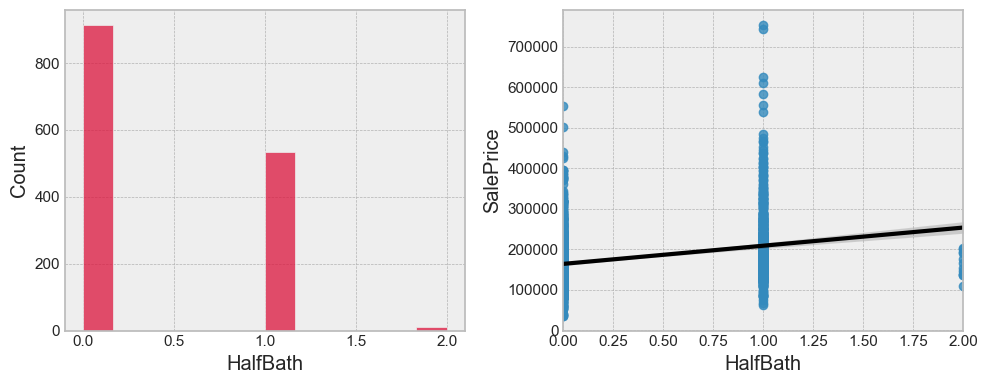

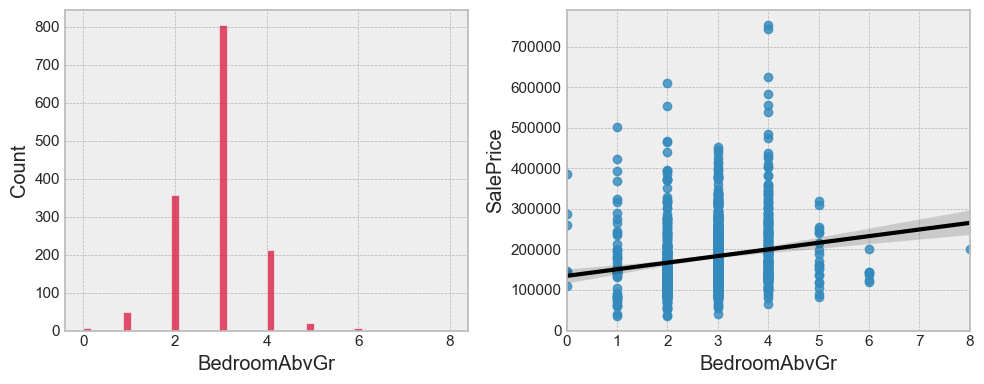

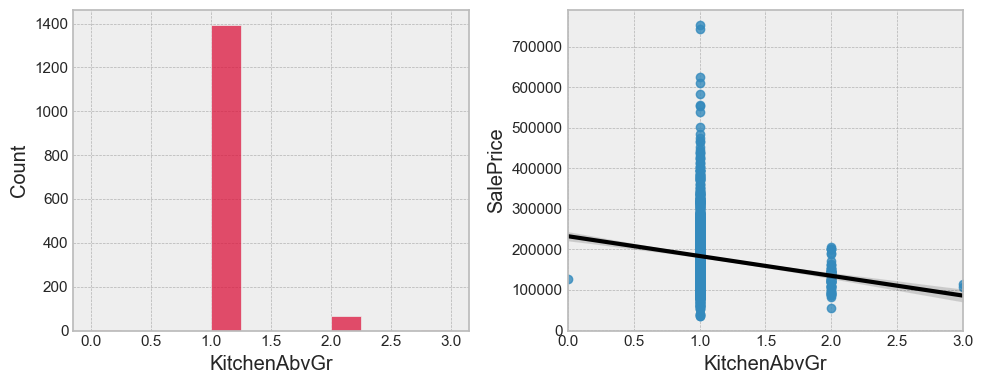

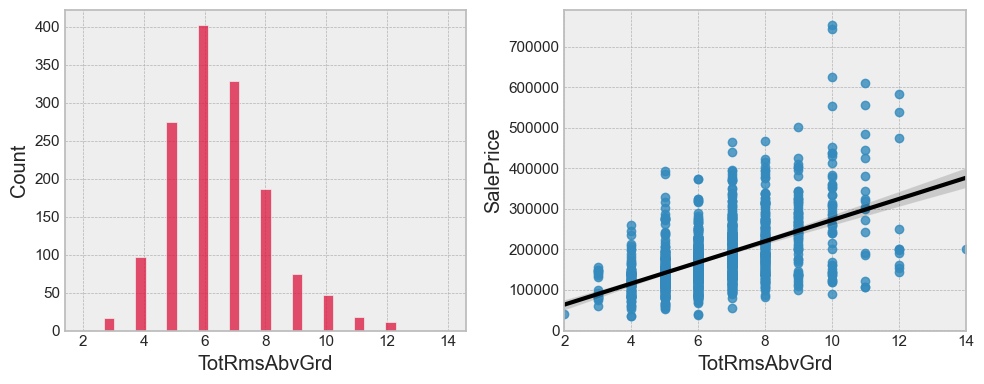

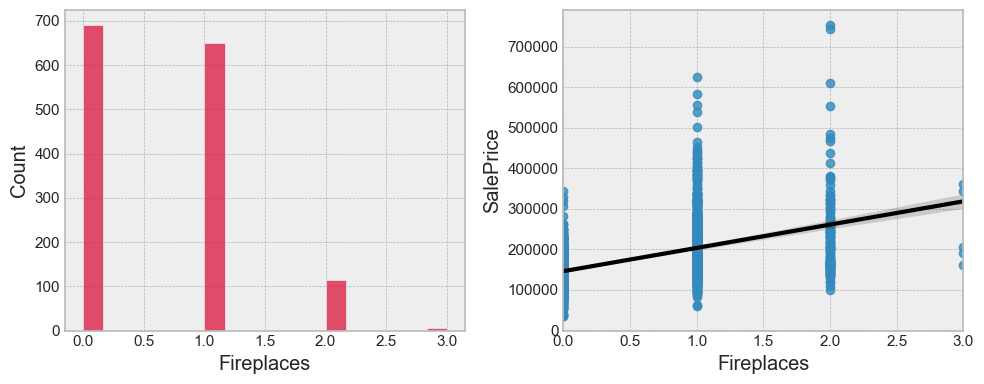

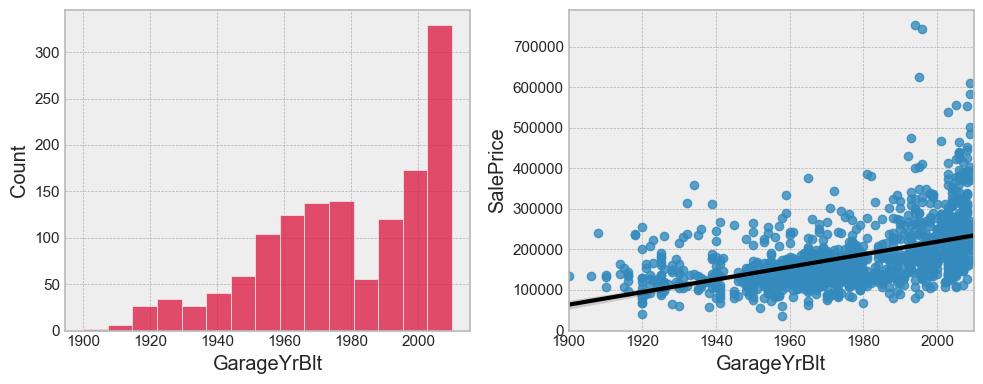

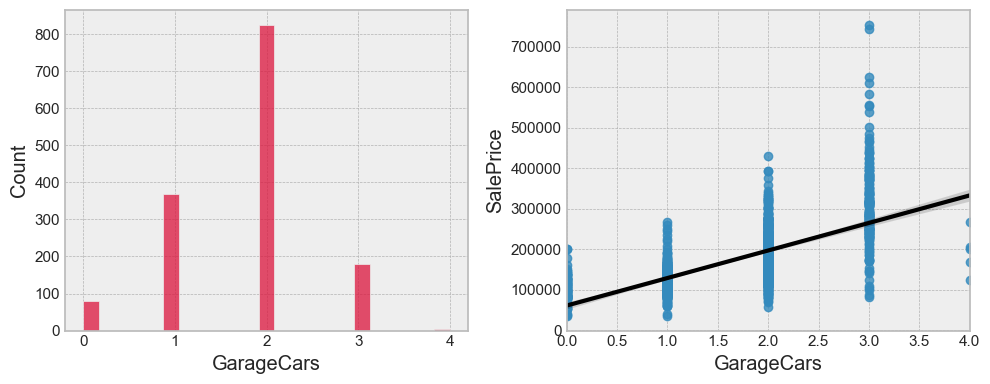

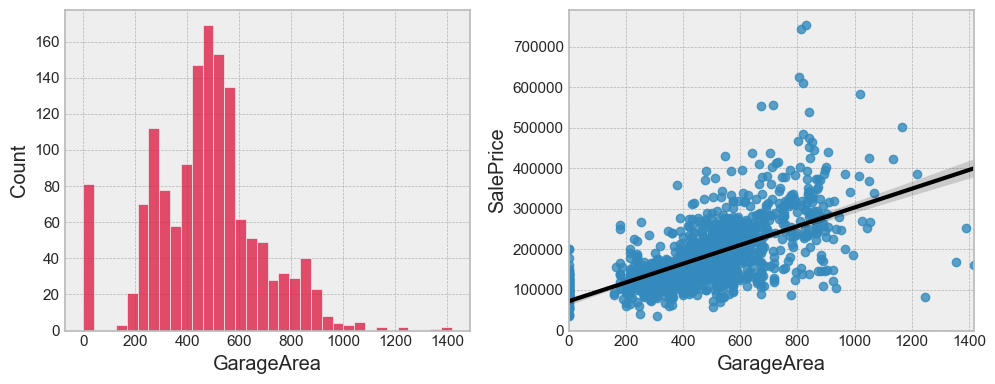

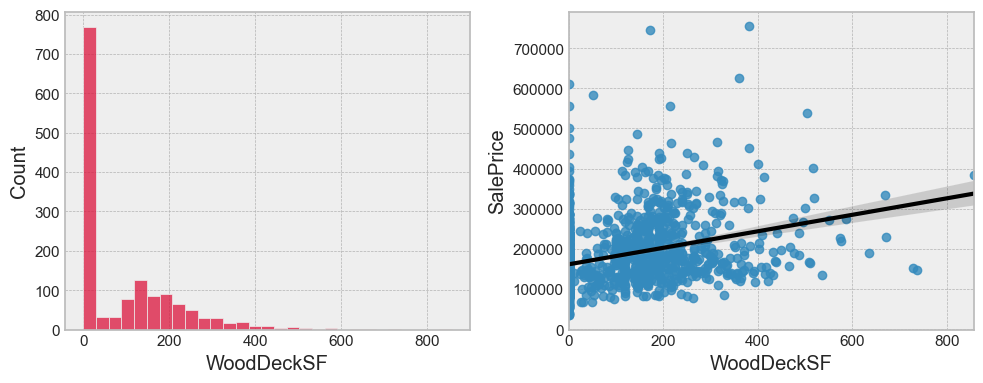

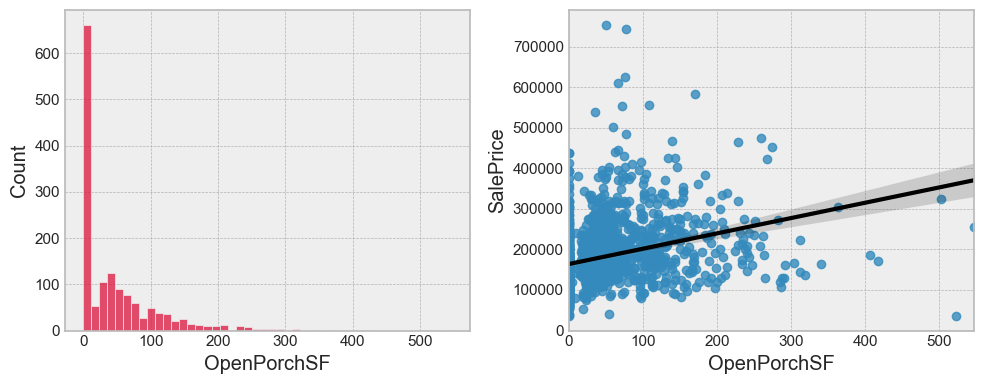

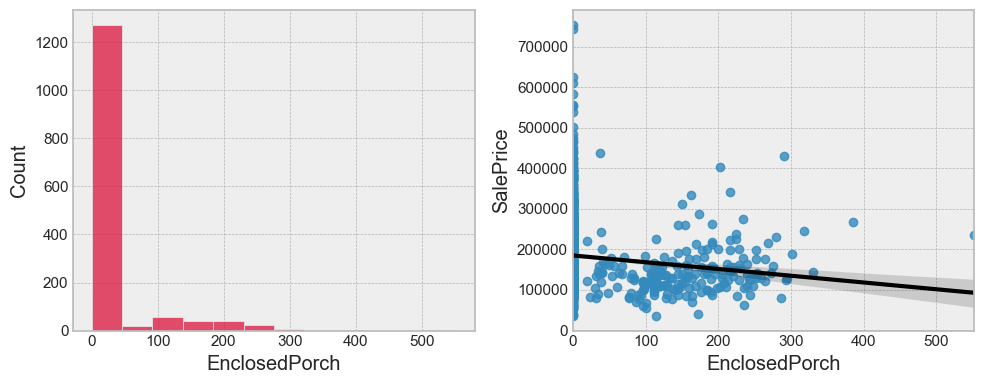

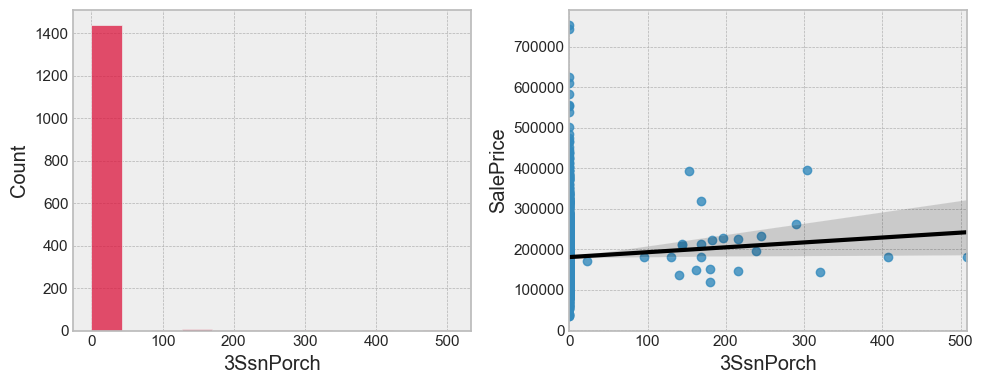

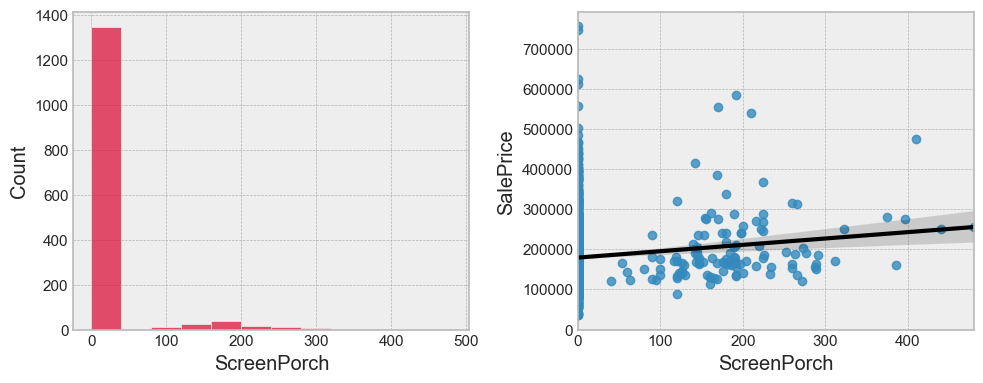

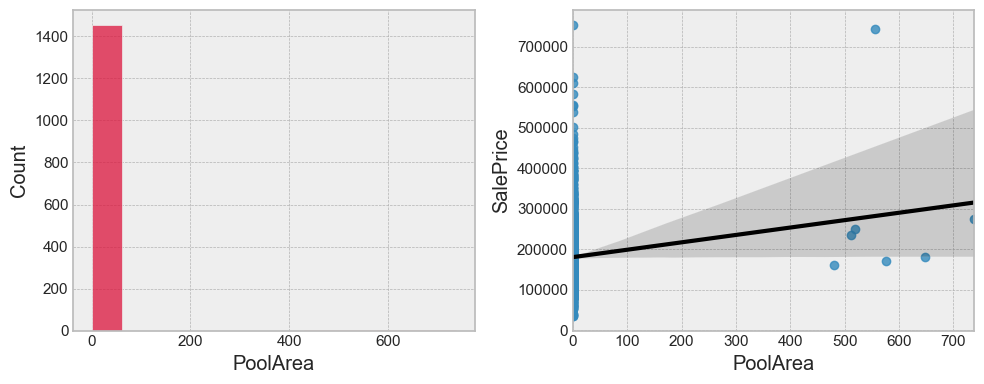

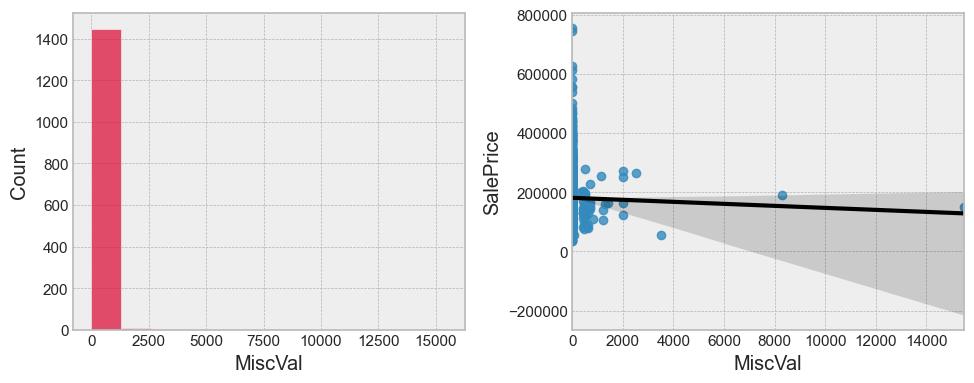

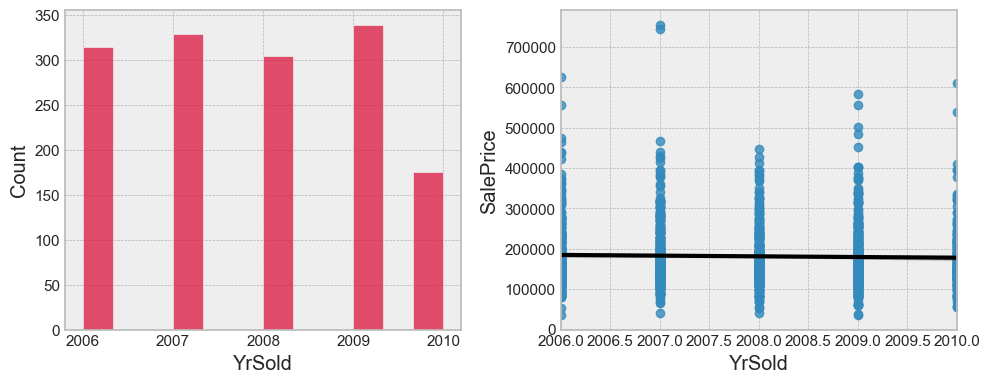

In [12]:
%%time
# Overview of distributions and relationship with label
def describe_num(df,col):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4)) # side-by-side distribution and scatter
    sns.histplot(df[col], color='crimson', ax=ax[0]) # distribution (hist) plot
    sns.regplot(x=col, y='SalePrice', data=df, line_kws={'color':'black'}, ax=ax[1]) # scatter plot with best-fit line
    plt.tight_layout()
    #print(df[col].describe())

for i in range(len(numeric_features)): 
    describe_num(df_train,numeric_features[i])
plt.close()

We can see that BsmtFinSF2, LowQualFinSF, BsmtHalfBath, 3SsnPorch, ScreenPorch, PoolArea, and MiscVal do not have much variation and a flat relationship with sales price.

In [13]:
# Drop variables with low predictive power
df_analysis = df.drop(columns='BsmtFinSF2 LowQualFinSF BsmtHalfBath 3SsnPorch ScreenPorch PoolArea MiscVal'.split())
numeric_features = df_analysis.dtypes[df_analysis.dtypes != "object"].index # a list of numeric features names
print('Number of numeric features:', len(numeric_features))

Number of numeric features: 28


#### Categorical features

Number of categorical features: 40


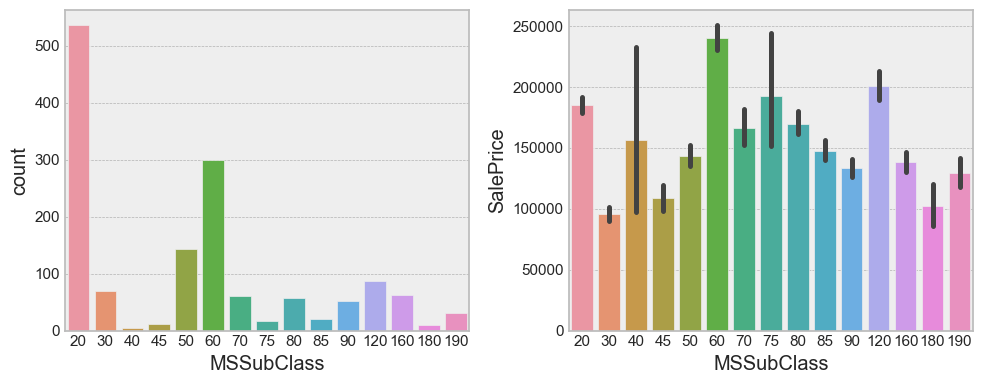

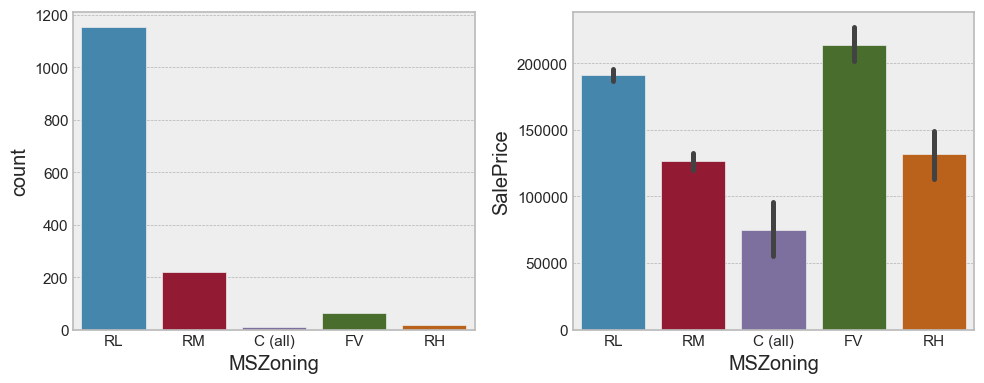

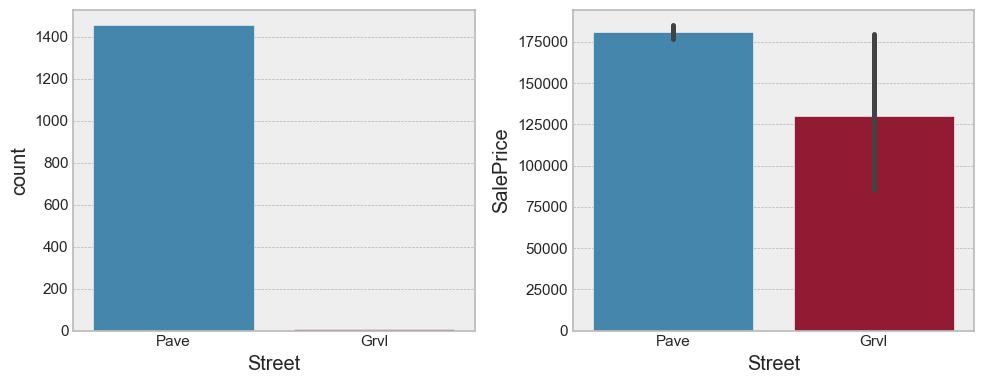

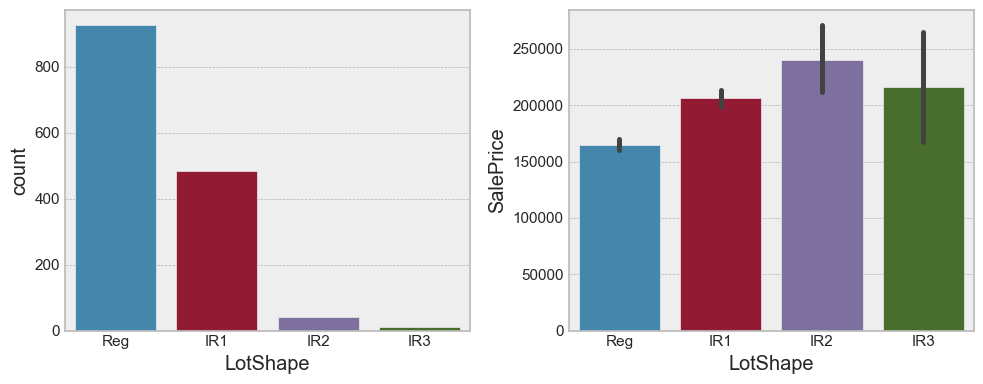

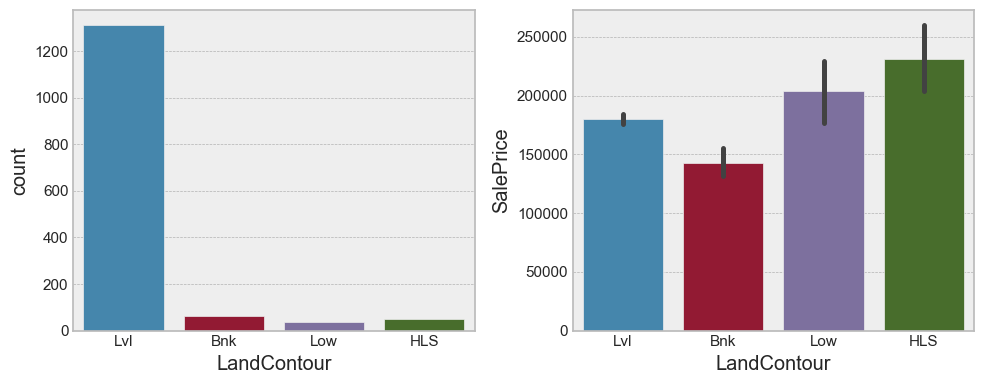

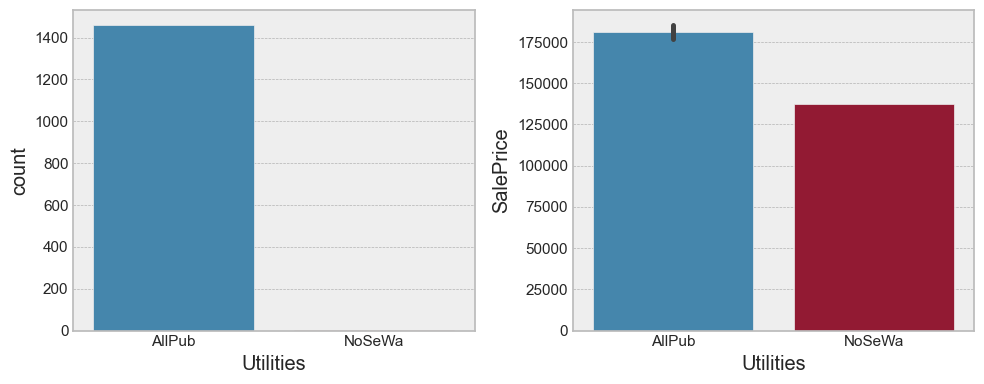

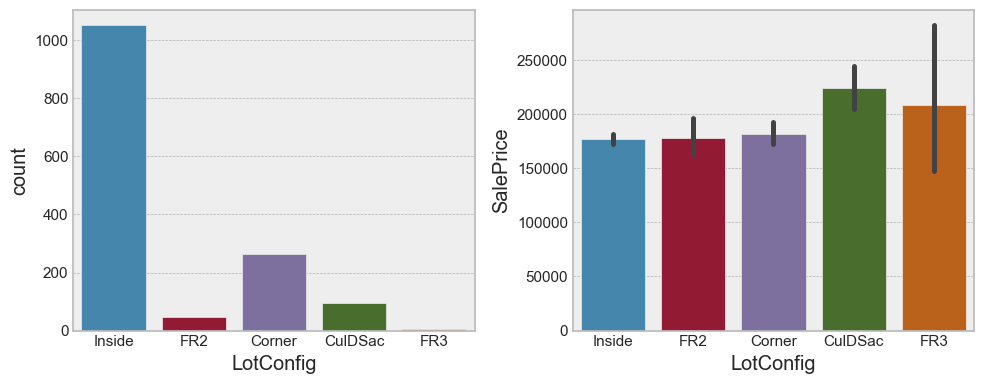

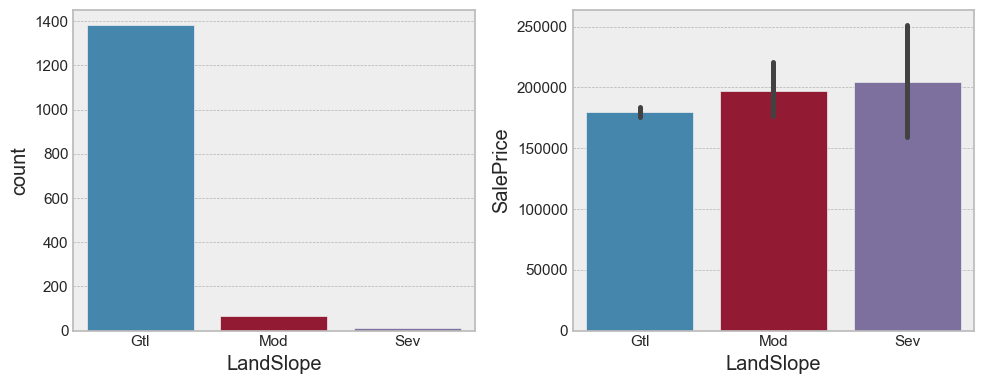

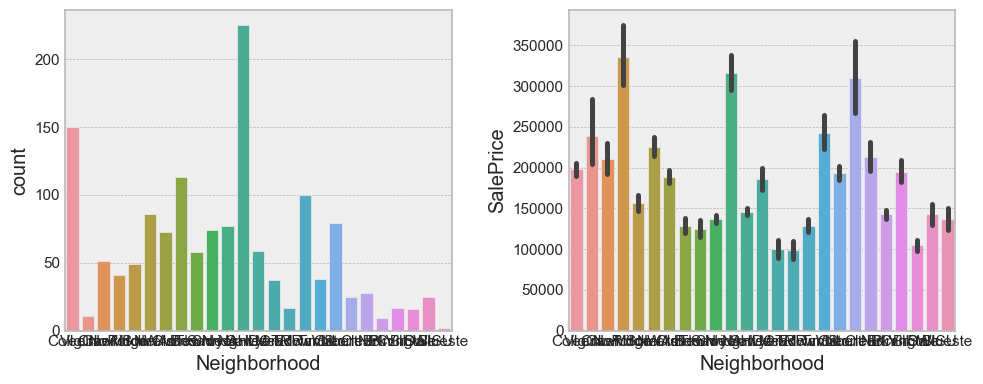

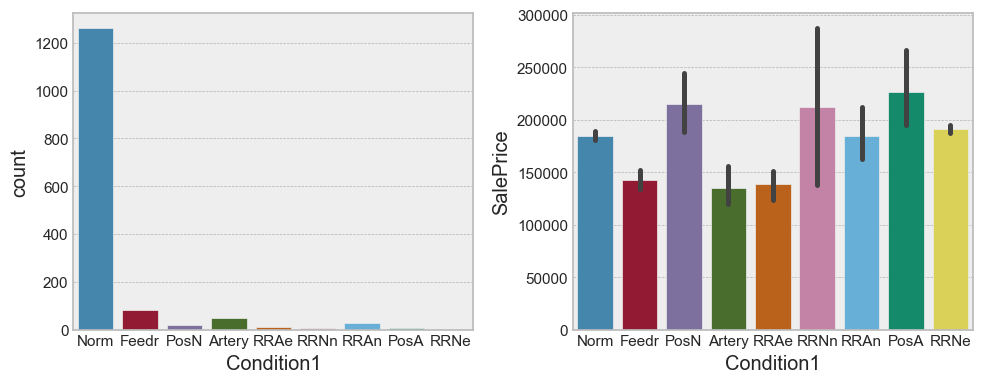

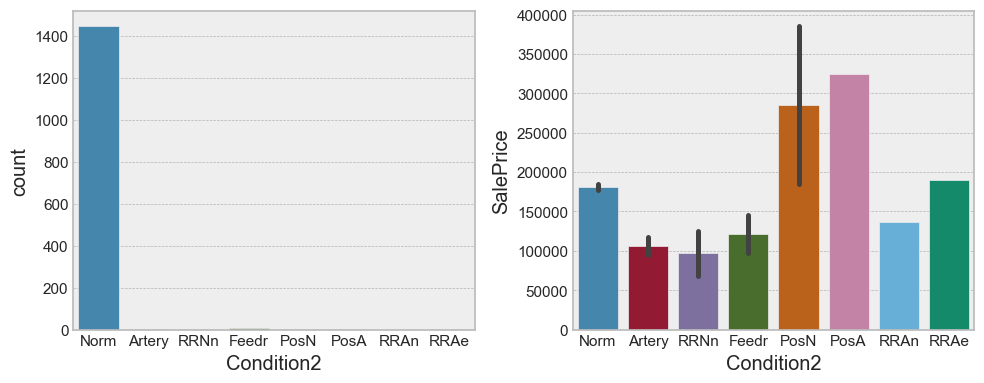

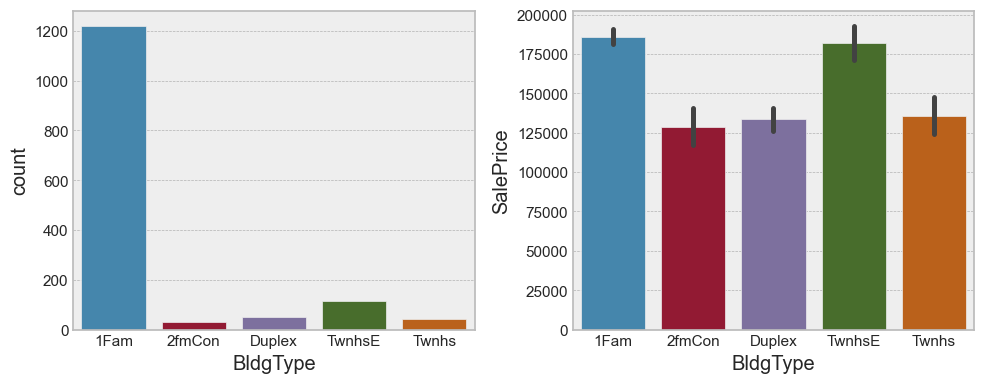

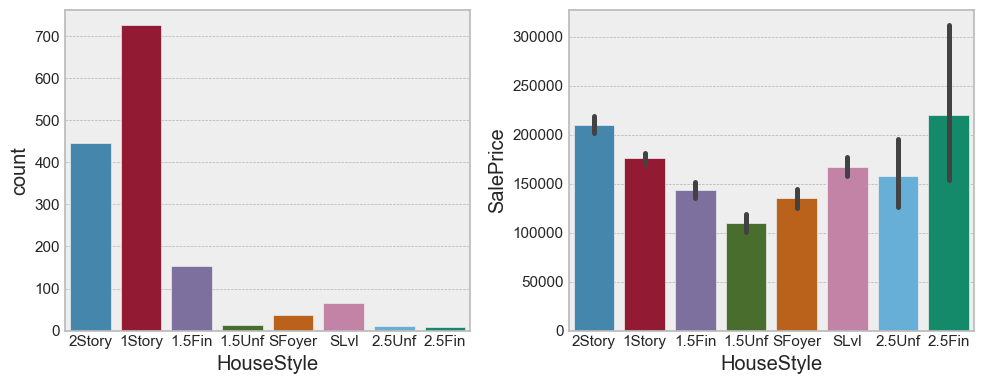

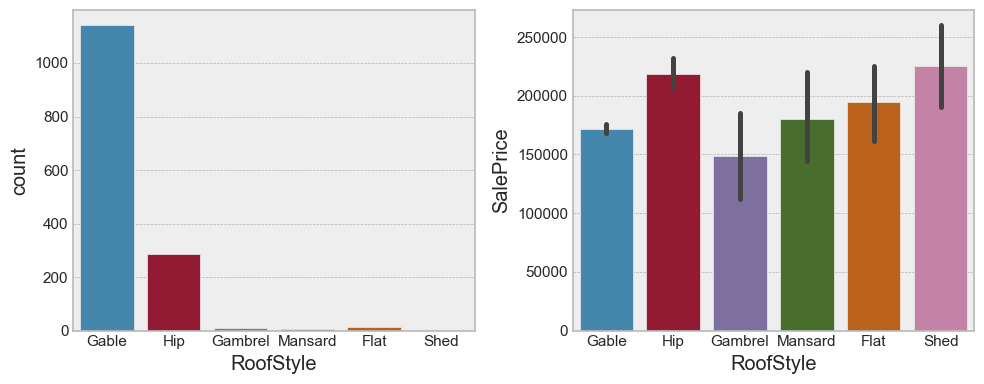

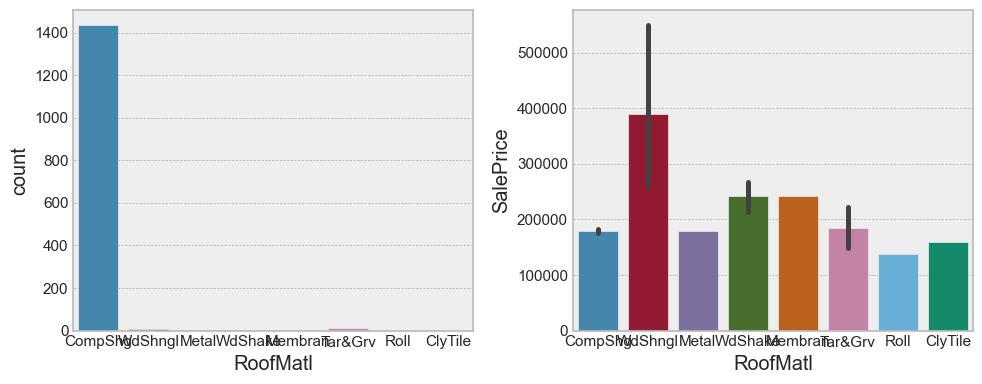

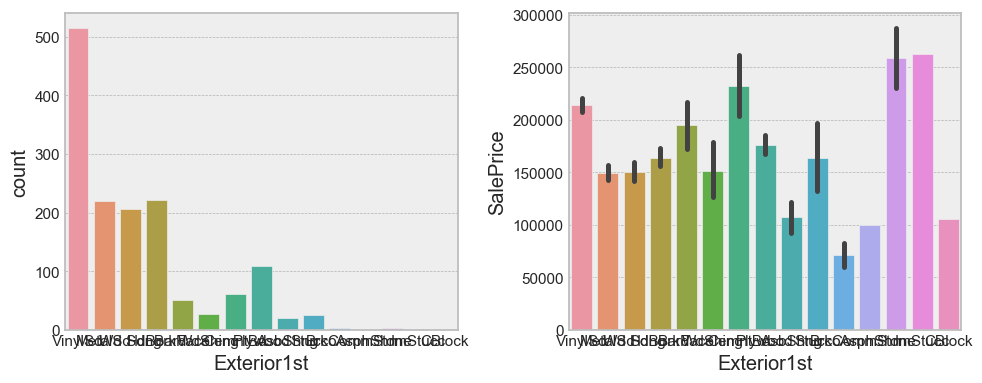

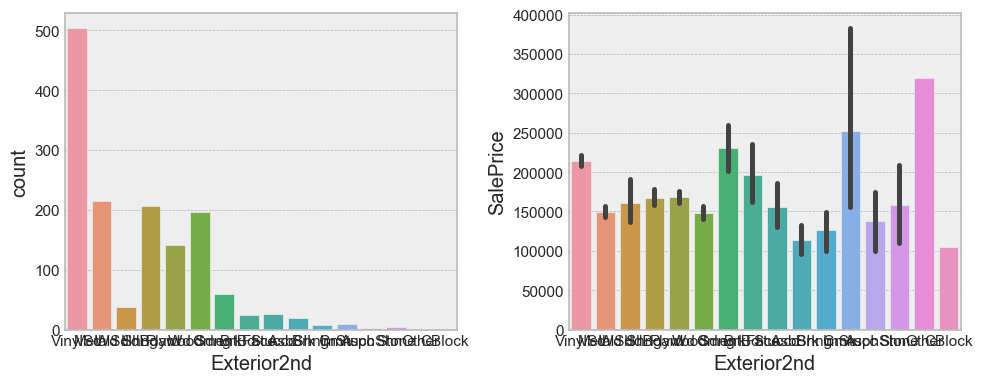

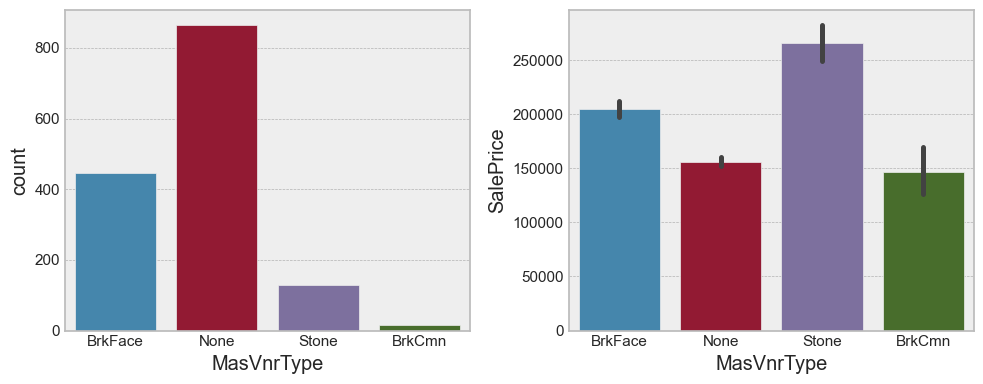

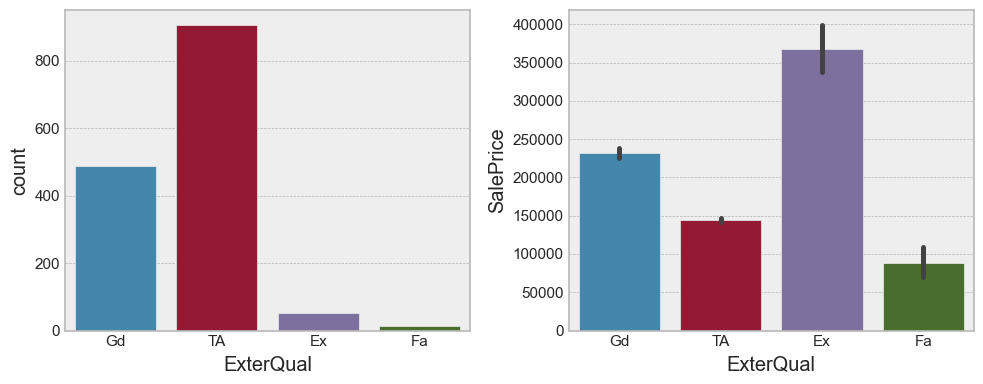

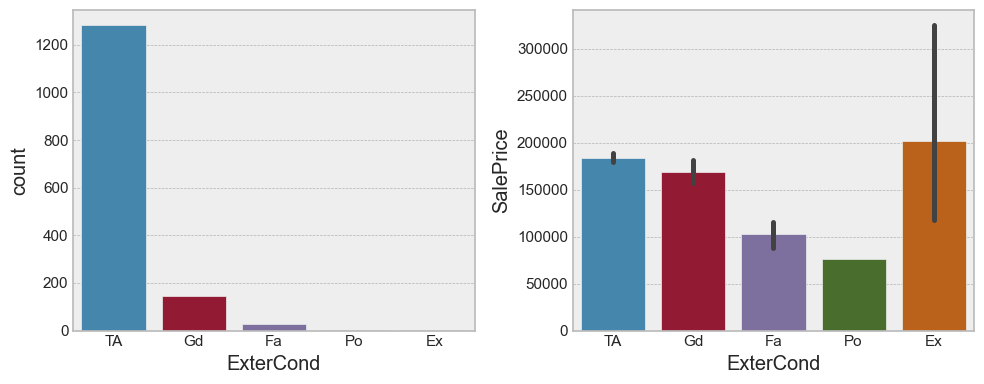

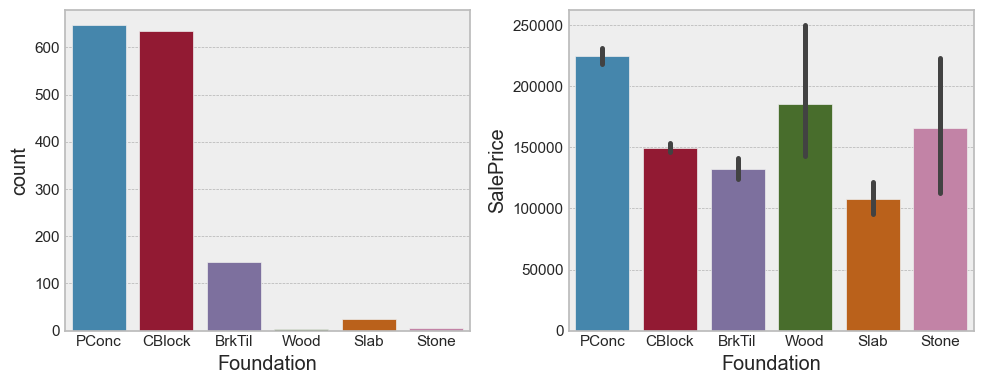

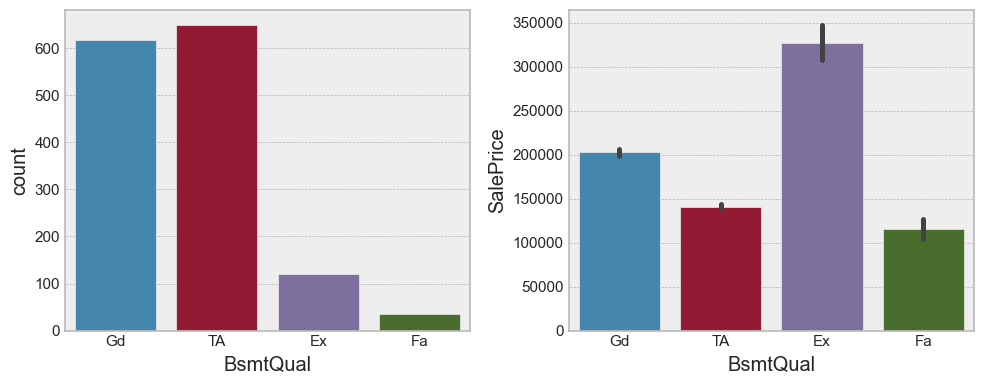

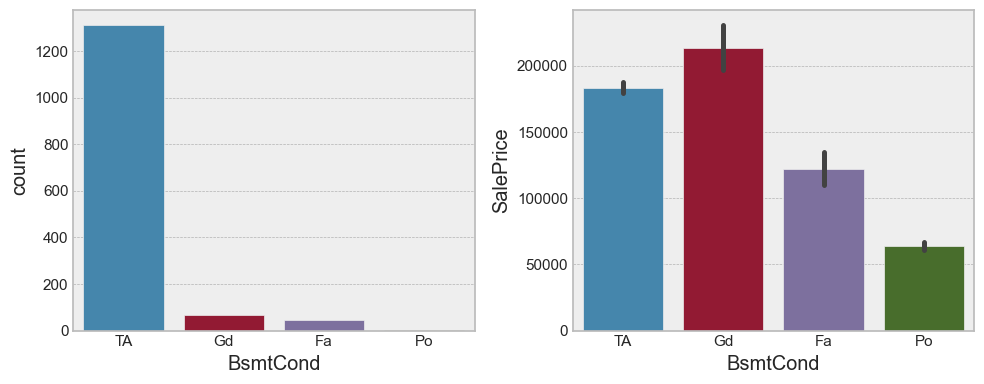

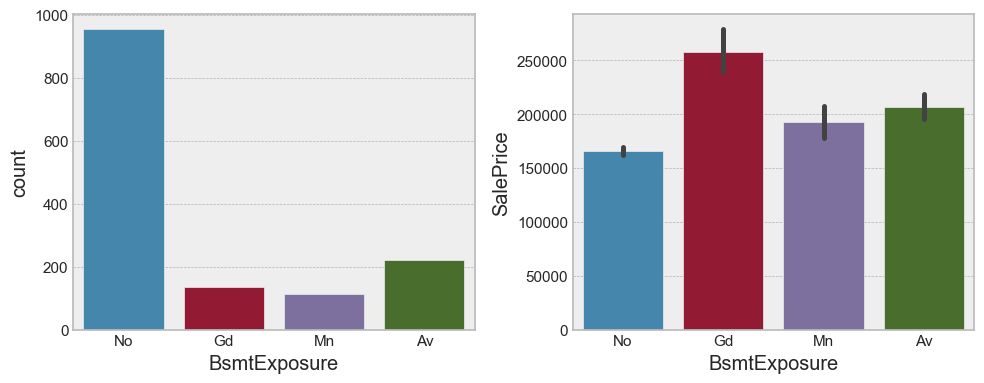

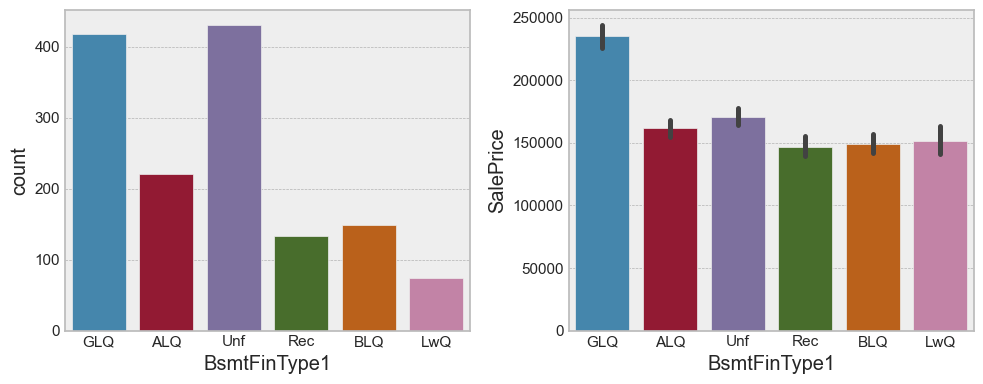

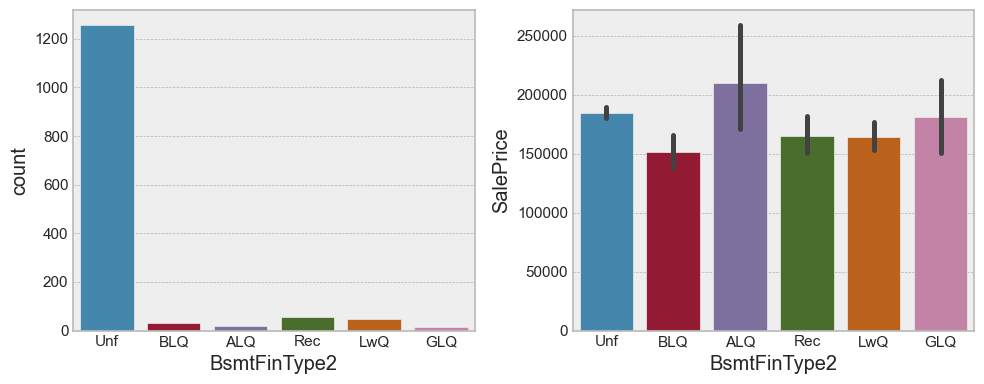

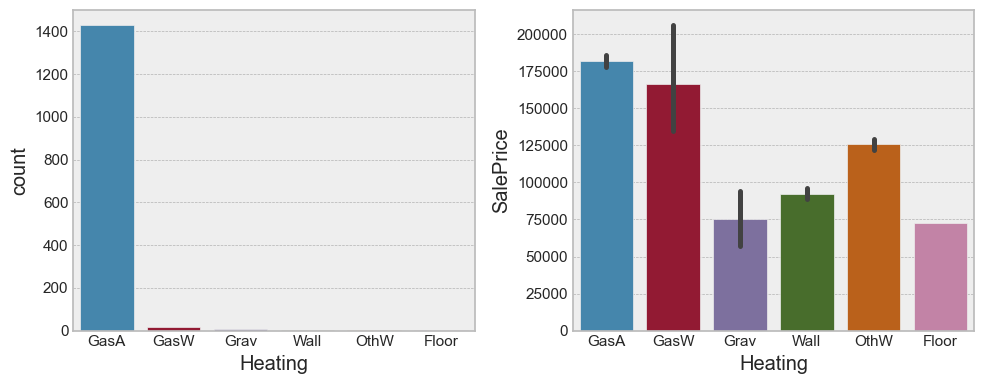

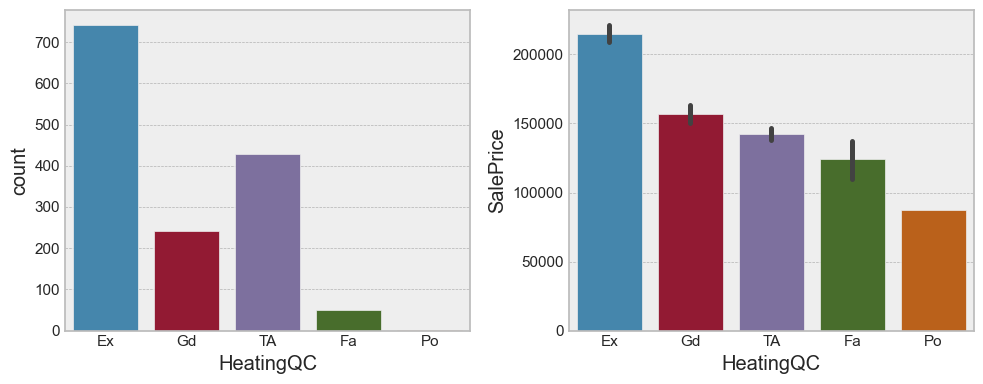

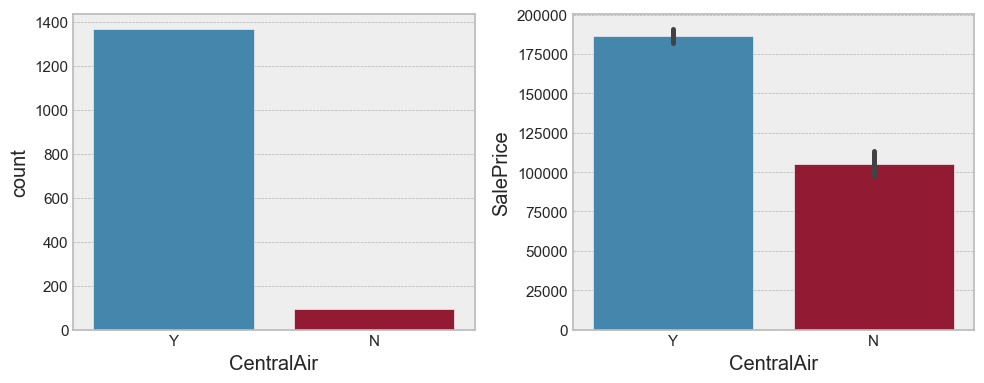

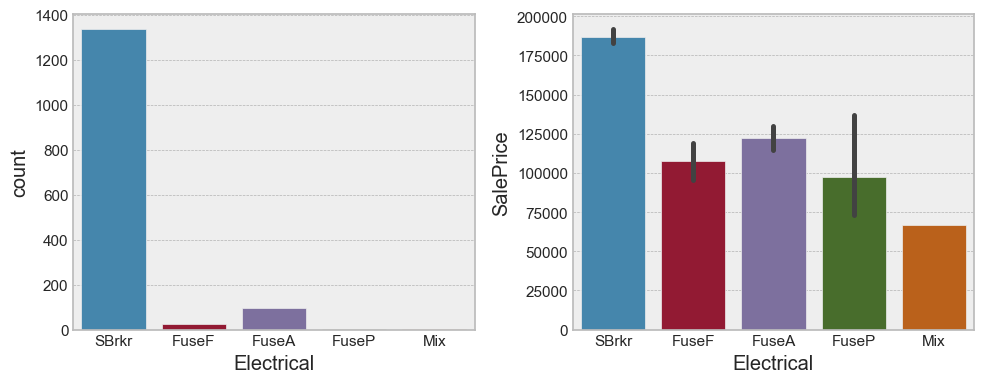

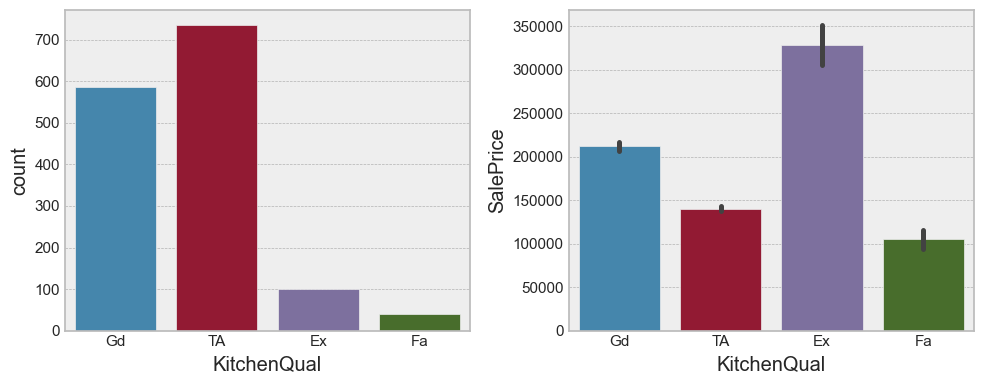

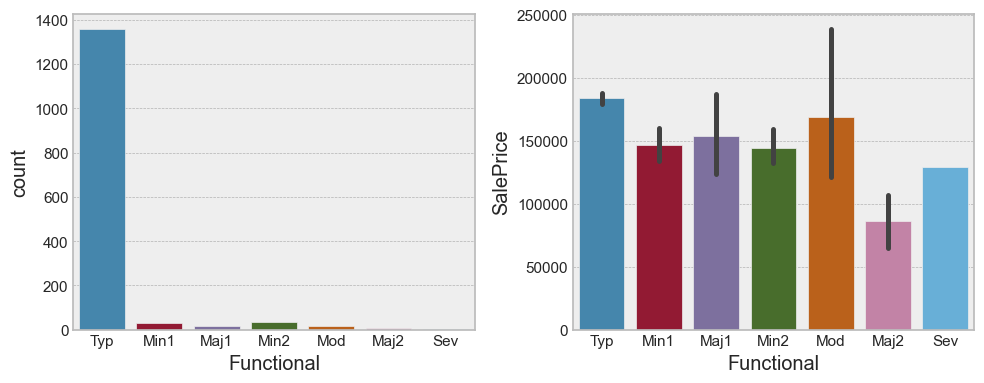

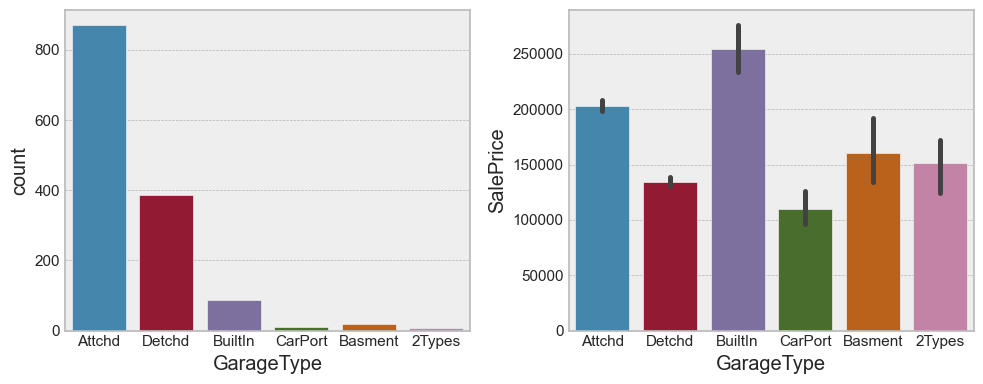

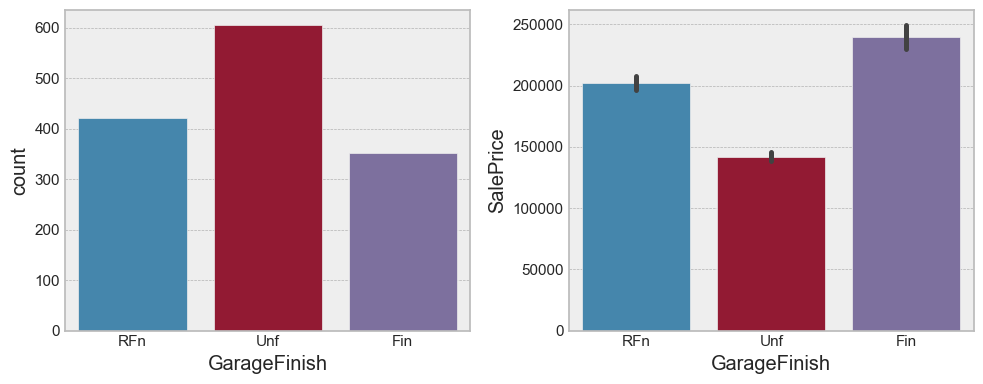

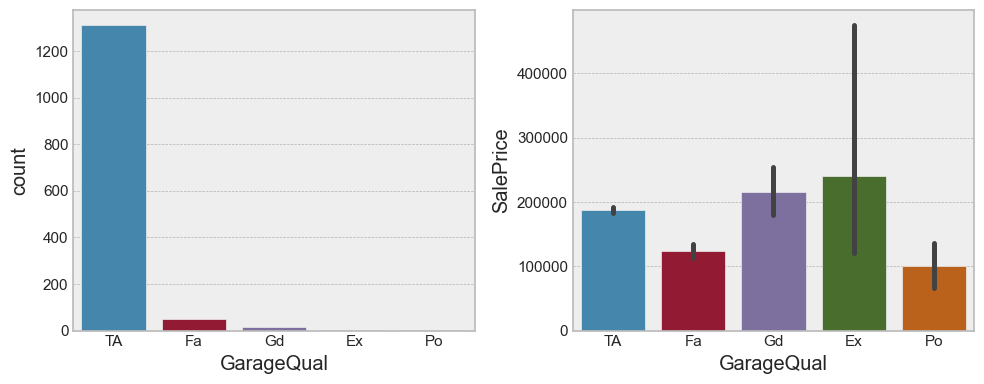

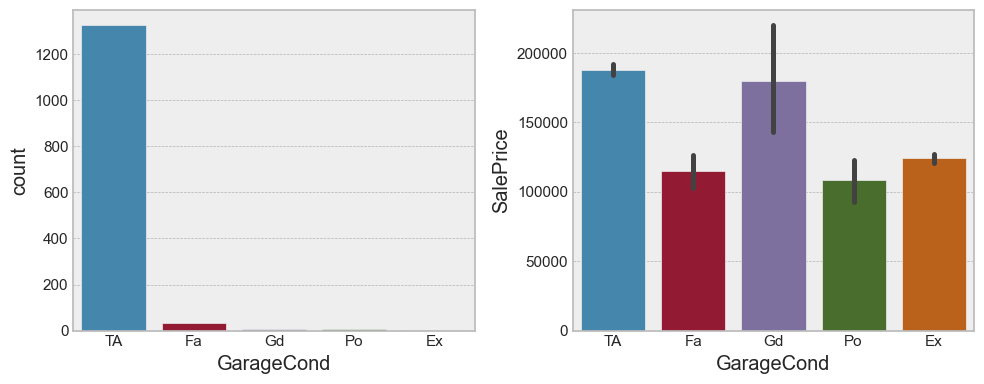

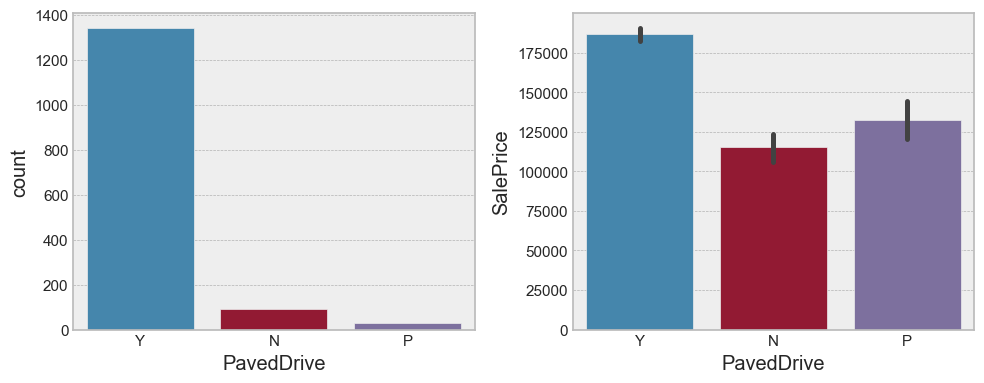

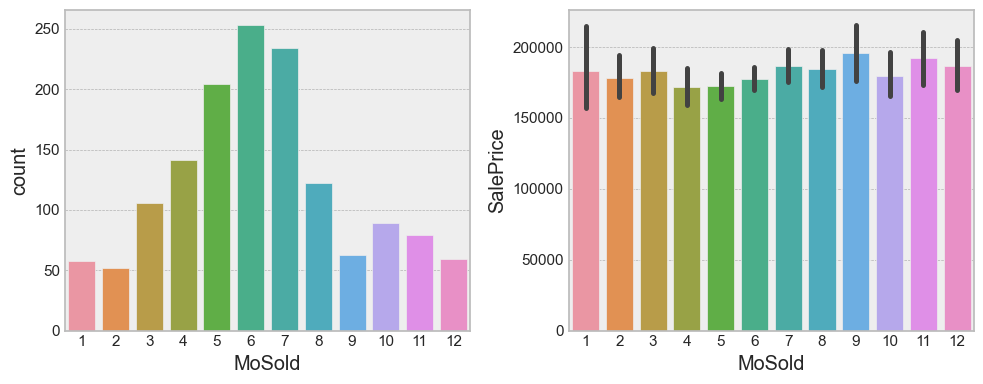

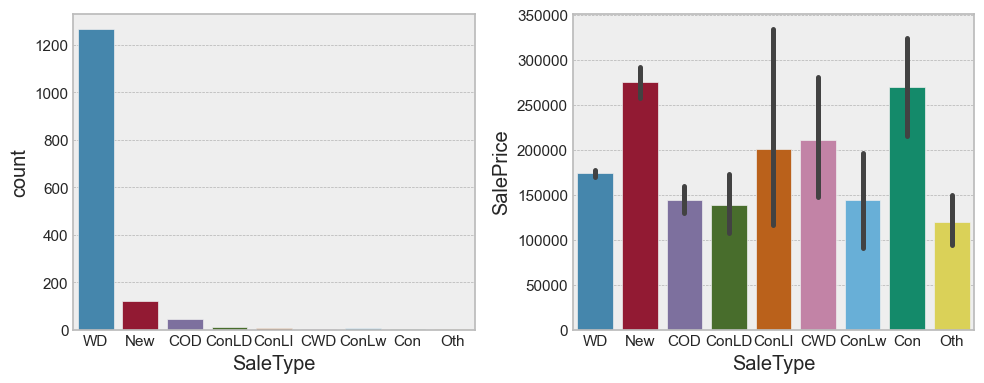

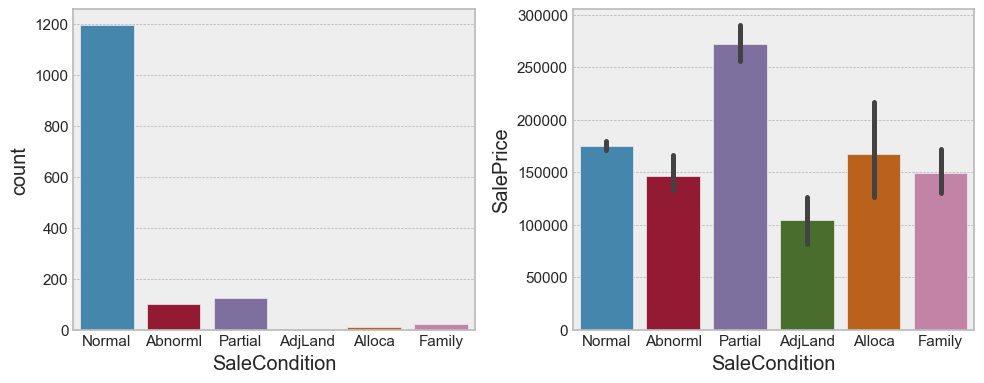

Wall time: 17.1 s


In [14]:
%%time
# Overview of distibutions
cat_features = df.dtypes[df.dtypes == "object"].index
print('Number of categorical features:', len(cat_features))

def describe_cat(df,col):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4)) # side-by-side distribution and scatter
    sns.countplot(x=col, data=df, ax=ax[0]) # distribution
    sns.barplot(x=col, y='SalePrice', data=df, ax=ax[1])
    plt.tight_layout()

for i in range(len(cat_features)): 
    describe_cat(df_train,cat_features[i])
    plt.show()
plt.close()

We can see that Street, Utilities, Condition2, RoofMatl, Heating, GarageQual, and GarageCond have low variability.

In [15]:
# Dropping low variability columns
df_analysis.drop(columns='Street Utilities Condition2 RoofMatl Heating GarageQual GarageCond'.split(), inplace=True)
cat_features = df_analysis.dtypes[df_analysis.dtypes == "object"].index
len(cat_features)

33

In [16]:
# Imputation of missing Categorical values
cat_imputes = pd.Series(list(set(cat_features).intersection(set(missing_vars))))
for cat in cat_imputes:
    df_analysis.loc[df_analysis[cat].isna(),cat] = df_analysis[cat].mode() # Set missing values as the most common category

In [17]:
# Create Dummies
df_analysis = pd.concat([df_analysis, pd.get_dummies(df_analysis[cat_features], drop_first=True)], axis=1)
df_analysis.drop(columns=cat_features, inplace=True, axis=1)
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Columns: 221 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(9), int64(19), uint8(193)
memory usage: 1.2 MB


C:\Users\morag\AppData\Local\Temp\ipykernel_15084\1732985951.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_analysis = pd.concat([df_analysis, pd.get_dummies(df_analysis[cat_features], drop_first=True)], axis=1)


#### Imputation and scaling of numeric features

In [18]:
# Imputation of missing Numeric values
print('Number of columns:', len(df_analysis.columns))
print('Number of rows:', len(df_analysis))
df_dropna = df_analysis.dropna() # use only rows with no missing values to train a linear regression model
X = df_analysis.columns[~df_analysis.isnull().any()] # use only columns with no missing values in the regression
print('Number of columns without NaN:', len(X))
print('Number of rows without NaN:', len(df_dropna))

numeric_imputes = pd.Series(list(set(numeric_features).intersection(set(missing_vars))))
for var in numeric_imputes:
    reg = linear_model.LinearRegression().fit(df_dropna[X], df_dropna[var]) # fit model on full columns and rows only
    df_analysis.loc[df_analysis[var].isna(),var] = reg.predict(df_analysis.loc[df_analysis[var].isna(),X]) # predict null values

Number of columns: 221
Number of rows: 2919
Number of columns without NaN: 212
Number of rows without NaN: 2267


In [19]:
# Standartize numeric variables with skewed distribution
skew = dict(df[numeric_features].skew())
skew = dict(sorted(skew.items(), key=lambda item: item[1], reverse=True))
print(skew.items())

scale_vars = 'GarageArea GrLivArea 1stFlrSF TotalBsmtSF BsmtUnfSF BsmtFinSF1 LotArea LotFrontage'.split()
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_analysis[scale_vars])
scaled_df = pd.DataFrame(scaled_df,columns=scale_vars) 
df_analysis = df_analysis.drop(columns=scale_vars)
df_analysis = df_analysis.join(scaled_df)
df_analysis.info()

dict_items([('LotArea', 12.829024853018762), ('KitchenAbvGr', 4.304466641562935), ('EnclosedPorch', 4.005950070504265), ('MasVnrArea', 2.6025885122682517), ('OpenPorchSF', 2.5364173160468444), ('WoodDeckSF', 1.8433802126628294), ('LotFrontage', 1.5032778146412304), ('1stFlrSF', 1.4703601055379227), ('BsmtFinSF1', 1.425722287785458), ('GrLivArea', 1.2700104075191514), ('TotalBsmtSF', 1.1628824745982715), ('BsmtUnfSF', 0.9198236977423032), ('2ndFlrSF', 0.8621178325657642), ('TotRmsAbvGrd', 0.7587568676624701), ('Fireplaces', 0.733871770878103), ('HalfBath', 0.6949236492716564), ('BsmtFullBath', 0.6240621985365326), ('OverallCond', 0.5706053117352524), ('BedroomAbvGr', 0.32649214927079917), ('GarageArea', 0.24130051733383068), ('OverallQual', 0.19721180528040133), ('FullBath', 0.16769191818882379), ('YrSold', 0.13246689568568673), ('train', -0.0006855185138570975), ('GarageCars', -0.21837276655710502), ('GarageYrBlt', -0.38215016096981613), ('YearRemodAdd', -0.45125229728739846), ('YearBu

In [20]:
# Split back to train and test
X_train = df_analysis.loc[df_analysis['train']==1].drop(columns='train')
y = df_train['log_price']
X_test = df_analysis.loc[df_analysis['train']==0].drop(columns='train')
print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

Train shape: (1460, 220)
Test shape: (1459, 220)


## Predictions

In [23]:
# Cross-validated RMSE and R2 to evaluate models
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', cv=5))
    return(rmse)

def r2_cv(model):
    r2 = cross_val_score(model, X_train, y, scoring='r2', cv=5)
    return(r2)

Best alpha: 12.0
RMSE: 0.14091297389277707
R2 0.8710859418950092
Wall time: 2.01 s


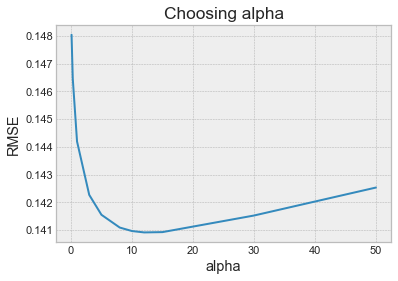

In [24]:
%%time
# Ridge
alphas = [0.1, 0.3, 1, 3, 5, 8, 10, 12, 15, 30, 50]
cv_ridge = [rmse_cv(linear_model.Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = 'Choosing alpha')
plt.xlabel('alpha')
plt.ylabel('RMSE')
print('Best alpha:', cv_ridge[cv_ridge == cv_ridge.min()].index[0])
print('RMSE:', cv_ridge.min())
print('R2', r2_cv(linear_model.Ridge(alpha = cv_ridge[cv_ridge == cv_ridge.min()].index[0])).mean())

Best alpha for l1_ratio=0: 0.01
RMSE: 0.1409171477829229
R2: 0.8417698743098485
Best alpha for l1_ratio=0.25: 0.001
RMSE: 0.1404593918741858
R2: 0.8721375159212575
Best alpha for l1_ratio=0.5: 0.001
RMSE: 0.1402739854580318
R2: 0.8721375159212575
Best alpha for l1_ratio=0.75: 0.0005
RMSE: 0.14046581496914498
R2: 0.8722057364929243
Best alpha for l1_ratio=1: 0.0005
RMSE: 0.14030438596098962
R2: 0.8722057364929243
Wall time: 19min 14s


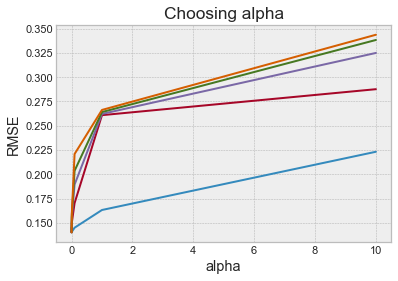

In [25]:
%%time
# Elastic Net
import warnings
from sklearn.exceptions import ConvergenceWarning

with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=ConvergenceWarning)
    alphas = [0.0005 ,0.001, 0.01, 0.1, 1, 10]
    ratio = [0, 0.25, 0.5, 0.75, 1]
    for l1 in ratio:
        cv_net = [rmse_cv(linear_model.ElasticNet(alpha = alpha, l1_ratio=l1, max_iter=100000)).mean() for alpha in alphas]
        cv_net = pd.Series(cv_net, index = alphas)
        cv_net.plot(title = 'Choosing alpha')
        plt.xlabel('alpha')
        plt.ylabel('RMSE')
        print(f'Best alpha for l1_ratio={l1}:', cv_net[cv_net == cv_net.min()].index[0])
        print('RMSE:', cv_net.min())
        print('R2:', r2_cv(linear_model.ElasticNet(alpha = cv_net[cv_net == cv_net.min()].index[0])).mean())

In [26]:
%%time
# XGBoost
xgb_param = {"max_depth": [3,5], "colsample_bytree": [0.3, 0.7], "learning_rate": [0.01, 0.05, 0.1],
             "n_estimators": [100, 500, 1000]} # Parameters to be tuned

xgb_cv = GridSearchCV(estimator=XGBRegressor(), param_grid=xgb_param, cv=5) # GridSearch
xgb_cv.fit(X_train, y)
print(f"Best hyperparameters: {xgb_cv.best_params_}")
print(f"Best R2: {xgb_cv.best_score_}")

Best hyperparameters: {'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000}
Best R2: 0.9096816271932132
Wall time: 4min 19s


In [27]:
%%time
# Using the best XGB model
best_xgb = XGBRegressor(colsample_bytree = xgb_cv.best_params_["colsample_bytree"],
                             learning_rate = xgb_cv.best_params_["learning_rate"],
                             max_depth = xgb_cv.best_params_["max_depth"],
                             n_estimators = xgb_cv.best_params_["n_estimators"])

print('RMSE:', rmse_cv(best_xgb).mean())
print('R2:', r2_cv(best_xgb).mean())

RMSE: 0.11986648968923042
R2: 0.9096816271932132
Wall time: 19.3 s


The best model according to RMSE and R2 is XGBoost ('colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000)

### Submission

In [28]:
# Transform prediction back to price
best_xgb.fit(X_train, y)
y_pred = best_xgb.predict(X_test)
sale_price = np.expm1(y_pred)
pd.Series(sale_price).to_csv(path+'submission.csv')